In [1]:
#%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
import json
from itertools import zip_longest
import os
from math import sqrt
import holidays
import seaborn as sns
import time
import datetime

# instance_varibles
# GLOBAL_VARIABLES

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

In [3]:
print(os.getcwd())

c:\Users\user\veritas


In [4]:
with open("../veritas_data/parser_menus/menu.json", "r") as f:
    MENU = json.load(f)

In [5]:
def load_ts_data(file_name, start_date=None):
    print("Loading main columns...")
    df = pd.read_csv(file_name, usecols=["device_id", "date", "store_id", "class", "total_price"], header=0)

    print("Formatting main columns...")
    df["device_id"], device_map = df["device_id"].factorize()
    df["store_id"], store_map = df["store_id"].factorize()
    df["class"], class_map = df["class"].factorize()
    df = df.astype("uint32")

    print("Loading products...")
    with open(file_name, "r") as f:
        num_columns = len(f.readline().split(","))
    for cols in zip_longest(*(iter(range(5, num_columns)),) * 50):
        cols = [c for c in cols if c is not None]
        temp_df = pd.read_csv(file_name, usecols=list(cols), header=0, dtype="uint8")
        temp_df = temp_df.loc[:, (temp_df != 0).any(axis=0)]   # Remove "zero" columns
        df = pd.concat([df, temp_df], axis=1)

    wl = [col for col in df.columns if col not in ['device_id', 'store_id', 'class', "date"]]
    df = df.drop(df[df[wl].eq(0).all(axis=1)].index)
    df['date'] = pd.to_datetime(df['date'], unit='s')
    if start_date is not None:
            df.drop(df[df["date"] < start_date].index, inplace=True)
    df.set_index(["store_id", "device_id", "date"], inplace=True)
    return df, device_map, store_map, class_map

In [6]:
TS_FILE = "../veritas_data/post_parser_orders/device_time_series.csv"
TSF, DEVICE_MAP, STORE_MAP, CLASS_MAP = load_ts_data(TS_FILE, "2020-01-01")

Loading main columns...
Formatting main columns...
Loading products...


In [7]:
# Returns the device_id, number of orders and the data frame of the device with the most orders
def get_top_devices(device_id_list, ts_frame, n):
    top_devices = []
    for device_id in device_id_list:
        df = ts_frame.loc[ts_frame["device_id"] == device_id, ["store_id"]]
        try:
            store_id = df.values[0][0]
        except:
            continue
        num_orders = len(df.index)
        top_devices.append((device_id, num_orders, store_id))
        top_devices = sorted(top_devices, key=lambda d: d[1], reverse=True)[:n]
    return top_devices

# Returns df without rows where col_name equals a value occuring less than threshold times
def trim_low_occurance_values(df, col_name, threshold):
    s = df[col_name].value_counts().ge(threshold)
    return df[df[col_name].isin(s[s].index)]

In [8]:
COL_WL = [col for col in TSF.columns if col not in ["device_id", "store_id", "class"]]

In [9]:
# 
def get_intervals(df, t_delta, sample_freq):
    first_date = df.index.min()[2].floor(sample_freq)
    last_date = (df.index.max()[2] + pd.Timedelta(sample_freq)).floor(sample_freq)
    time_step = last_date
    intervals = []
    while time_step > first_date:
        start = time_step-t_delta
        end = time_step
        intervals.append((start, end))
        time_step -= t_delta
    return intervals


In [10]:
TSF.drop("class", axis=1, inplace=True)

START, END = get_intervals(TSF, pd.Timedelta(1, unit="W"), SAMPLE_FREQUENCY)[0]
DEVICE1 = TSF[(TSF.index > START) & (TSF.index <= END)].groupby(["device_id"]).get_group(0)
DEVICE1 = format_ts(DEVICE1, START, END, SAMPLE_FREQUENCY)
DEVICE2 = TSF[(TSF.index > START) & (TSF.index <= END)].groupby(["device_id"]).get_group(1)
DEVICE2 = format_ts(DEVICE2, START, END, SAMPLE_FREQUENCY)

In [214]:
#from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, pairwise_distances
#from sklearn.preprocessing import minmax_scale
from scipy.spatial.distance import squareform, pdist

def error_func(df1, df2):
    return mean_absolute_error(df1,df2)#np.sqrt(mean_squared_error(df1[col], df2[col]))

def superior_error(df1, df2):
    return mean_absolute_error(df1,df2)

def reindex_by_date(df, start, end, freq, fill_value=0):
    dates = pd.date_range(start=start, end=end, freq=freq)
    index = list(set(df.index.droplevel("date").tolist()))
    index.sort()
    dates = [(i, j, d) for i, j in index for d in dates]
    df = df.reindex(dates).fillna(0)
    return df

def flatten_ts(df):
    return df.values.flatten()

# 
def format_ts(df, start, end, freq, whitelist, flatten=False, normalize=False, sales_percentage=False):
    product_cols = [col for col in df.columns if "product" in col]
    df.rename(columns={"total_price": "average_price"}, inplace=True)
    agg_dict = {col_name:np.sum for col_name in df.columns}
    agg_dict.update({"average_price":np.mean})
    df = df.groupby([df.index.get_level_values(i) for i in [0,1]]+[pd.Grouper(freq=freq, level=-1)]).agg(agg_dict)
    df = reindex_by_date(df, start, end, freq)

    if sales_percentage:
        df[product_cols] = df[product_cols].div(df[product_cols].sum(axis=1), axis=0)
    if normalize:
        df -= df.min()
        df /= df.max()

    df = df.fillna(0)

    if flatten:
        df.index.droplevel("store_id")
        device_index = df.index.get_level_values("device_id").unique()
        df = df.groupby(level="device_id").apply(flatten_ts)
        df = pd.DataFrame(np.stack(df), index=device_index)
    return df

def correlation_matrix(df, start, end, freq, whitelist, dist_func, normalize=False, sales_percentage=False):
    start_time = time.time()
    ids = df.index.get_level_values("device_id").unique()
    err_df = pd.DataFrame(index=ids, columns=ids)

    print("Formatting devices...")
    df = format_ts(df, start, end, freq, whitelist, normalize=normalize, sales_percentage=sales_percentage, flatten=True)

    print("Generating correlation matrix...")
    err_df = pd.DataFrame(squareform(pdist(df, metric="euclidean")), columns=df.index, index=df.index)
    print("Done!", "\tElapsed time:", str(datetime.timedelta(seconds=(time.time()-start_time))))
    return err_df

def distance_score(df):
    df -= df.min().min()
    df /= df.max().max()
    #df = 1 - df
    return df


In [215]:
START, END = get_intervals(TSF, pd.Timedelta(1, unit="W"), SAMPLE_FREQUENCY)[2]
print(START, "--", END)
INTERVAL = TSF[(TSF.index.get_level_values("date") > START) & (TSF.index.get_level_values("date") <= END)]
#format_ts(INTERVAL.loc[0:1], START, END, SAMPLE_FREQUENCY, COL_WL, flatten=True, sales_percentage=True)
#INTERVAL.loc[0, 0].values.flatten().shape
#ERR = correlation_matrix(INTERVAL, START, END, SAMPLE_FREQUENCY, COL_WL, mean_absolute_error, normalize=False)

2020-01-29 19:00:00 -- 2020-02-05 19:00:00
Formatting devices...
Generating correlation matrix...
Done! 	Elapsed time: 0:00:29.797429


In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
X = [[i] for i in [2, 8, 0, 4, 1, 9, 9, 0]]
Z = linkage(SCORE, "ward")
fig = plt.figure(figsize=(35, 10))
dn = dendrogram(Z)
Z = linkage(SCORE, "single")
fig = plt.figure(figsize=(35, 10))
dn = dendrogram(Z)
Z = linkage(SCORE, "complete")
fig = plt.figure(figsize=(35, 10))
dn = dendrogram(Z)
Z = linkage(SCORE, "average")
fig = plt.figure(figsize=(35, 10))
dn = dendrogram(Z)
plt.show()

In [216]:
device_to_store = [s for (s, _) in INTERVAL.index.droplevel("date").unique().values]

In [272]:
#from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
n_stores = len(set(device_to_store))
n_clusters = 15
SAMPLE_FREQUENCY = "2H"

INTERVALS = get_intervals(TSF, pd.Timedelta(1, unit="W"), SAMPLE_FREQUENCY)
SCORES = []
for START, END in INTERVALS:
    print(START, "--", END)
    INTERVAL = TSF[(TSF.index.get_level_values("date") > START) & (TSF.index.get_level_values("date") <= END)]

    DF = format_ts(INTERVAL, START, END, SAMPLE_FREQUENCY, COL_WL, flatten=True, normalize=True)
    DIST = pdist(DF, metric="euclidean")
    LINK = linkage(DIST, method="complete")
    BEST_SCORE = (-1,0)
    for N_CLUST in range(2, len(DF)):
        CLUST = fcluster(LINK, t=N_CLUST, criterion="maxclust")
        SIL_SCORE = silhouette_score(squareform(DIST), CLUST, metric="precomputed")
        if SIL_SCORE > BEST_SCORE[0]:
            BEST_SCORE = (SIL_SCORE, N_CLUST)
    SCORES.append(BEST_SCORE)
#agg_clust = AgglomerativeClustering(n_clusters=n_clusters, affinity="euclidean", linkage="complete")
#clusters = agg_clust.fit_predict(SCORE)

2020-02-12 20:00:00 -- 2020-02-19 20:00:00
2020-02-05 20:00:00 -- 2020-02-12 20:00:00
2020-01-29 20:00:00 -- 2020-02-05 20:00:00
2020-01-22 20:00:00 -- 2020-01-29 20:00:00
2020-01-15 20:00:00 -- 2020-01-22 20:00:00
2020-01-08 20:00:00 -- 2020-01-15 20:00:00
2020-01-01 20:00:00 -- 2020-01-08 20:00:00
2019-12-25 20:00:00 -- 2020-01-01 20:00:00


In [273]:
SCORES

[(0.1698868619307628, 2),
 (0.11315385801913819, 2),
 (0.3081576048756805, 2),
 (0.2702774011227361, 5),
 (0.43636630414466954, 2),
 (0.2949583484359473, 2),
 (0.33569749641389734, 2),
 (0.4091457108806264, 2)]

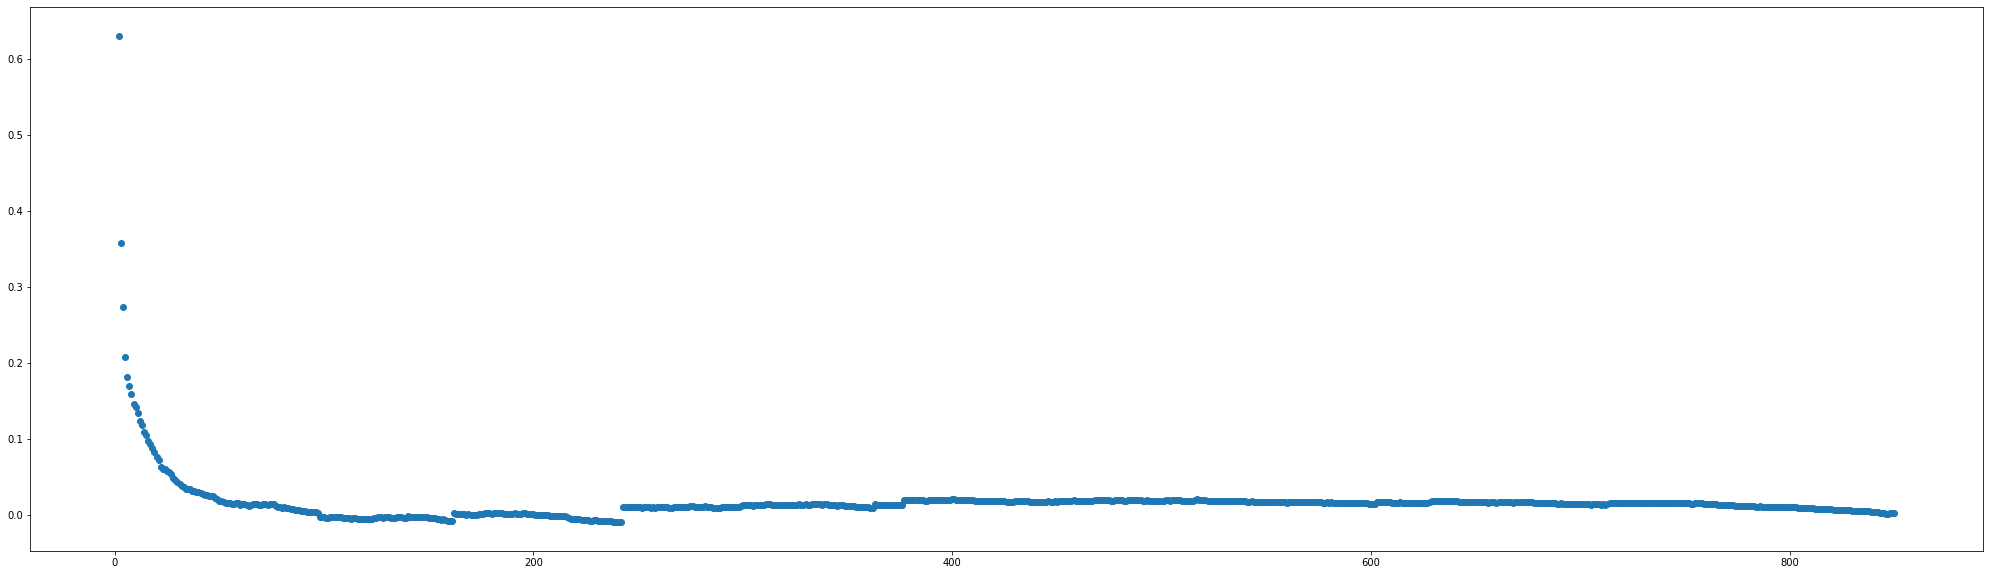

In [269]:
plt.figure(figsize=(35, 10))
plt.scatter(range(2, len(DF)), SCORES)

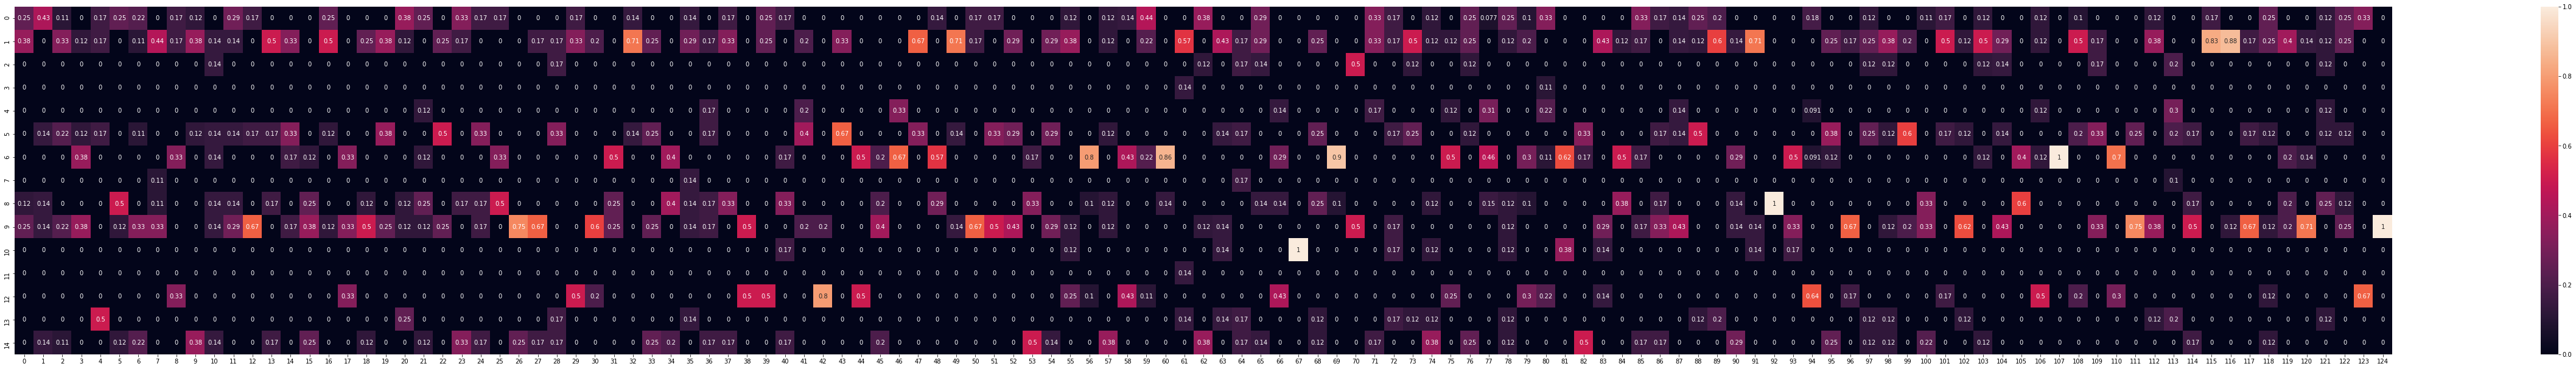

In [227]:
plt.rcParams.update({"font.size": 10})
plt.figure(figsize=(0.7*n_stores, 0.7*n_clusters))
I = np.unique(np.array([device_to_store, clusters]).T, axis=0, return_counts=True)
A = np.zeros((n_stores,n_clusters))
A[I[0][:,0], I[0][:,1]] = I[1]
A = A.T
sns.heatmap(A/A.sum(axis=0), annot=True)

In [ ]:
plt.rcParams.update({"font.size": 22})
plt.figure(figsize=(35, 10))
plt.scatter(device_to_store, clusters)
plt.show()

In [15]:
plt.subplots(figsize=(215,200))
plt.rcParams.update({"font.size": 150})
SLICE=1000
ax = sns.heatmap(ERR.iloc[:SLICE, :SLICE].fillna(0), mask=ERR.iloc[:SLICE, :SLICE].isna())
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position("top")
plt.savefig("output.png")
plt.show()

In [ ]:
sns.heatmap(ERR.fillna(0), mask=ERR.isna())

In [ ]:
sns.heatmap(ERR.fillna(0), mask=ERR.isna())

In [ ]:
a = pd.DataFrame([[1,1,1],[2,2,2],[3,3,3]])
b = pd.DataFrame([[1,2,3],[3,2,1],[3,3,3]])
print(a.values)
print(a.values.flatten())

In [ ]:
DEVICES = get_top_devices(range(len(DEVICE_MAP)), trim_low_occurance_values(TSF, "device_id", 1000), 10)
print(DEVICE_MAP[DEVICES[0][0]], DEVICES[0][0], DEVICES[0][1])

In [ ]:
def get_top_cols(df, row_index, n_cols):
    if len(df) == 0:
        return []
    row_frame = df.iloc[row_index].copy()
    columns = []
    for _ in range(n_cols):
        if len(row_frame) == 0:
            break
        col_id = row_frame.idxmax()
        columns.append(col_id)
        row_frame = row_frame.drop([col_id])
    return columns

In [ ]:
def get_color_dict(labels):
    #labels = [col for col in df.columns if col not in ["device_id", "date", "store_id", "class", "total_price"]]
    colors = [cm.rainbow(i) for i in np.linspace(0, 1, len(labels))]
    c_dict = {}
    for i, label in enumerate(labels):
        c_dict[label] = colors[i]
    return c_dict

START_INDEX = 0
N_COLS = 6
COL_SET = set()
for D in DEVICES:
    DEVICE_FRAME = TSF.loc[TSF["device_id"] == D[0], COL_WL].copy()
    DEVICE_FRAME = DEVICE_FRAME.drop(["total_price"], axis=1)
    DEVICE_FRAME = DEVICE_FRAME.resample("H").sum().iloc[START_INDEX:]
    DEVICE_FRAME = DEVICE_FRAME.cumsum()
    for C in get_top_cols(DEVICE_FRAME, -1, N_COLS):
        COL_SET.add(C)
COLOR_DICT = get_color_dict(COL_SET)

for D in DEVICES:
    DEVICE_FRAME = TSF.loc[TSF["device_id"] == D[0], column_whitelist].copy()
    if len(DEVICE_FRAME) == 0:
        continue
    DEVICE_FRAME = DEVICE_FRAME.drop(["total_price"], axis=1)
    DEVICE_FRAME = DEVICE_FRAME.resample("H").sum().iloc[START_INDEX:]
    DEVICE_FRAME = DEVICE_FRAME.cumsum()
    COLS = get_top_cols(DEVICE_FRAME, -1, N_COLS)
    fig = plt.figure()
    DEVICE_FRAME.plot(kind='line',y=COLS, figsize=(16, 10), color=[COLOR_DICT.get(x, '#666666') for x in COLS], linewidth=3.0)
    plt.legend(prop={'size': 18})
    plt.figtext(.5,.9, "Device "+str(D[0])+", Store "+str(D[2]),fontsize=24)
    #plt.show()
    plt.savefig("C:/Users/user/Desktop/store_/"+str(D[2]+"/"+"device_"+str(D[0])+"_day.png")
    plt.close(fig)

In [ ]:
def add_time_cols(df):
    df["hour"] = df.index.hour
    df["day_of_week"] = df.index.dayofweek
    df["day_of_month"] = df.index.day
    df["month"] = df.index.month
    holidays_swe = holidays.Sweden(include_sundays=False)[df.index[0]: df.index[-1]]
    df["holiday"] = [1 if d in holidays_swe else 0 for d in df.index.date]

def remove_zero_sequence(df, col, min_length):
    mask = col.groupby((col != col.shift()).cumsum()).transform('count').lt(min_length)
    mask = ~(mask | col.gt(0))
    df.drop(mask[mask].index, axis=0, inplace=True)

In [ ]:
def get_test_train_split(df, train_len=pd.Timedelta(4, unit='W'), forecast_len=pd.Timedelta(1, unit='W'), expanding_window=False):
    start = df.index.values[0]
    split = start + train_len
    forecast_end = split + forecast_len
    end = df.index.values[-1]
    sets = []
    while end > forecast_end:
        sets.append((df[start:split].index, df[split:forecast_end].index))
        if not expanding_window:
            start += train_len + forecast_len
        split += train_len + forecast_len
        forecast_end += train_len + forecast_len
    return sets

DEVICE_FRAME = TSF.loc[TSF["device_id"] == DEVICES[0][0], COL_WL].copy()
len(get_test_train_split(DEVICE_FRAME))

In [ ]:
from statsmodels.tsa.vector_ar.var_model import VAR

def train_and_predict_var(train_set, n_steps):
    model = VAR(endog=train_set)
    model_fit = model.fit(maxlags=2, trend="nc")
    print(model_fit.y)
    return
    prediction = model_fit.forecast(model_fit.y, steps=n_steps)
    return prediction

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

def validate(predictions, true_val):
    sum_meanAE = mean_absolute_error(predictions, true_val).sum()
    sum_medianAE = median_absolute_error(predictions, true_val).sum()
    return sum_meanAE, sum_medianAE

In [ ]:
DEVICE_FRAME = TSF.loc[TSF["device_id"] == DEVICES[0][0], COL_WL].copy()
#DEVICE_FRAME["orders"] = 1
AGG_DICT = {col_name:np.sum for col_name in DEVICE_FRAME.columns}
AGG_DICT.update({"total_price":np.mean})
DEVICE_FRAME = DEVICE_FRAME.resample("H").agg(AGG_DICT).fillna(0).cumsum()
DEVICE_FRAME.rename(columns={'total_price': 'average_price'}, inplace=True)
DEVICE_FRAME.drop(["average_price"], axis=1, inplace=True)
#remove_zero_sequence(DEVICE_FRAME, DEVICE_FRAME.orders, 25)
#add_time_cols(DEVICE_FRAME)

test_train = get_test_train_split(DEVICE_FRAME)
pred = train_and_predict_var(DEVICE_FRAME.loc[test_train[0][0]], len(test_train[0][1]))
validate(pred, DEVICE_FRAME.loc[test_train[0][1]])

SUM_TRUE = DEVICE_FRAME.loc[test_train[0][1]]#DEVICE_FRAME.loc[test_train[0][0]].append(DEVICE_FRAME.loc[test_train[0][1]])
PRED = pd.DataFrame(index=SUM_TRUE.index,columns=SUM_TRUE.columns)
for j in range(0,len(DEVICE_FRAME.loc[test_train[0][1]].columns)):
    for i in range(0, len(pred)):
       PRED.iloc[i][j] = pred[i][j]
SUM_VAR = PRED
COLS = get_top_cols(SUM_TRUE, -1, 5)
COLOR_DICT = get_color_dict(COLS)
_, ax = plt.subplots()
SUM_TRUE.plot(ax=ax, kind='line',y=COLS, figsize=(20, 14), color=[COLOR_DICT.get(x, '#FFFFFF') for x in COLS], linewidth=3.0)
SUM_VAR.plot(linestyle='dashed', ax=ax, kind='line',y=COLS, figsize=(20, 14), color=[COLOR_DICT.get(x, '#FFFFFF') for x in COLS], linewidth=3.0)
plt.legend(prop={'size': 18})
plt.show()

In [ ]:
for train, test in get_test_train_split(DEVICE_FRAME, pd.Timedelta(4, unit='W'), pd.Timedelta(1, unit='W')):
    train = DEVICE_FRAME.loc[train]
    test = DEVICE_FRAME.loc[test]#-train.iloc[-1]
    pred = train_and_predict_var(train, len(test))
    #validate(pred, test)

    SUM_TRUE = test#DEVICE_FRAME.loc[test_train[0][0]].append(DEVICE_FRAME.loc[test_train[0][1]])
    PRED = pd.DataFrame(index=test.index,columns=test.columns)
    for j in range(0,len(test.columns)):
        for i in range(0, len(pred)):
            PRED.iloc[i][j] = pred[i][j]
    SUM_VAR = PRED#-train.iloc[-1]
    COLS = get_top_cols(SUM_TRUE, -1, 5)
    COLOR_DICT = get_color_dict(COLS)
    _, ax = plt.subplots()
    train.append(SUM_TRUE).plot(ax=ax, kind='line',y=COLS, figsize=(20, 14), color=[COLOR_DICT.get(x, '#FFFFFF') for x in COLS], linewidth=3.0)
    SUM_VAR.plot(linestyle='dashed', ax=ax, kind='line',y=COLS, figsize=(20, 14), color=[COLOR_DICT.get(x, '#FFFFFF') for x in COLS], linewidth=3.0)
    plt.legend(prop={'size': 18})
    plt.show()

plt.scatter(DEVICE_FRAME.index, DEVICE_FRAME["orders"].cumsum())
plt.figure(figsize=(20,100))

TRAIN_PERCENT = 0.8
TRAIN_SIZE = -336#int(len(DEVICE_FRAME)*TRAIN_PERCENT)
TRAIN_Y = DEVICE_FRAME[:TRAIN_SIZE]
TRAIN_Y = TRAIN_Y.loc[:, (TRAIN_Y != TRAIN_Y.iloc[0]).any()]
VAL_Y = DEVICE_FRAME[TRAIN_Y.columns][TRAIN_SIZE:]
#TRAIN_X = DEVICE_FRAME["day"]
#VAL_X = DEVICE_FRAME["day"]

#creating the train and validation set
train = TRAIN_Y
valid = VAL_Y
naive_pred = DEVICE_FRAME[TRAIN_SIZE-1:-1]

#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit()

# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(valid))

In [ ]:
#converting predictions to dataframe
pred = pd.DataFrame(index=valid.index,columns=VAL_Y.columns)
for j in range(0,len(VAL_Y.columns)):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

#check rmse
print("MAE VAR, MAE Naive, Min Val, Max Val")
MIN = valid.min()
MAX = valid.max()
SUM_MAE = 0
for i in pred.columns:
    SUM_MAE += mean_absolute_error(pred[i], valid[i])
    print('MAE value for', str(i)+':\t', mean_absolute_error(pred[i], valid[i]), "\t", mean_absolute_error(naive_pred[i], valid[i]), "\t", MIN[i], "\t", MAX[i])
print("AVG MAE:", (SUM_MAE/len(VAL_Y.columns)))

#converting predictions to dataframe
pred = pd.DataFrame(index=valid.index,columns=DEVICE_FRAME.columns)
for j in range(0,len(DEVICE_FRAME.columns)):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

#check rmse
print("RMSE for VAR predictions and Naive Predictions")
for i in DEVICE_FRAME.columns:
    print('rmse value for', i, 'is : ', sqrt(mean_squared_error(pred[i], valid[i])), "\t", sqrt(mean_squared_error(naive_pred[i], valid[i])))

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

DEVICE_FRAME = sc.fit_transform(DEVICE_FRAME)
DEVICE_FRAME.min()